In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/case-6-actual-data/actual_data_6.csv


In [3]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 pandapower==2.14.6 pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 65.4 MB/s eta 0:00:0000:010:01m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 52.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 112.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import pandapower as pp, pickle
import os, math, pickle
from tqdm import tqdm
import ot
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-11-27 18:11:46.259243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764267106.453159      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764267106.513003      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
net = pp.networks.case6ww()
NUM_BUS = 6
BASE_MVA = 100

DATA_CSV = "/kaggle/input/case-6-actual-data/actual_data_6.csv"
YBUS_NPZ = "Ybus.npz"
PANDAPOWER_NET_PKL = "pandapower_net.pkl"
OUT_CSV = "ddim_stochastic_constrained_generated.csv"  # this is for non-decoupled

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_FEATURES = 4 * NUM_BUS
BATCH_SIZE = 64
EPOCHS = 1000
LR = 1e-4
TIMESTEPS = 1000
DDIM_STEPS = 300
ETA = 0.2
SAMPLE_COUNT = 5000
GUIDANCE_LAMBDA = 1e-4

In [8]:
# ============================================================
# Data loading, Ybus, normalization (same as before)
# ============================================================
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError("Need actual_data.csv generated from PF dataset code.")
actual = pd.read_csv(DATA_CSV)
cols = actual.columns.tolist()
if actual.shape[1] != NUM_FEATURES:
    raise ValueError(f"Dataset must have {NUM_FEATURES} columns.")
data = actual.values.astype(np.float32)

def load_ybus():
    nb = len(net.bus)
    Y = np.zeros((nb, nb), dtype=complex)
    for _, row in net.line.iterrows():
        i, j = int(row["from_bus"]), int(row["to_bus"])
        r, x = row["r_ohm_per_km"], row["x_ohm_per_km"]
        length = row.get("length_km", 1.0)
        y = 1 / complex(r * length, x * length)
        Y[i, i] += y; Y[j, j] += y; Y[i, j] -= y; Y[j, i] -= y
    return np.real(Y), np.imag(Y)

G_np, B_np = load_ybus()
G = torch.tensor(G_np, dtype=torch.float32, device=DEVICE)
B = torch.tensor(B_np, dtype=torch.float32, device=DEVICE)

xmin, xmax = data.min(axis=0), data.max(axis=0)
range_eps = (xmax - xmin).copy()
range_eps[range_eps == 0] = 1e-6

def normalize(x):
    return 2 * (x - xmin) / range_eps - 1

def denormalize(xn):
    return ((xn + 1) / 2) * range_eps + xmin

data_tensor = torch.tensor(normalize(data), dtype=torch.float32, device=DEVICE)

# ============================================================
# Decoupling helpers: [P, Q, V, Theta] → ([P, Theta], [Q, V])
# ============================================================
def split_vec(x):
    p  = x[:, :NUM_BUS]
    q  = x[:, NUM_BUS:2*NUM_BUS]
    v  = x[:, 2*NUM_BUS:3*NUM_BUS]
    th = x[:, 3*NUM_BUS:4*NUM_BUS]
    return torch.cat([p, th], dim=1), torch.cat([q, v], dim=1)

def concat_vec(x1, x2):
    p  = x1[:, :NUM_BUS]
    th = x1[:, NUM_BUS:]
    q  = x2[:, :NUM_BUS]
    v  = x2[:, NUM_BUS:]
    return torch.cat([p, q, v, th], dim=1)

# ============================================================
# Diffusion schedule (same idea as before)
# ============================================================
def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T, device=DEVICE)

betas = linear_beta_schedule(TIMESTEPS)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, 0)

# ============================================================
# Denoiser (same architecture style, but for half-dim)
# ============================================================
class MLPDenoiser(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096),    nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096),    nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, dim)
        )

    def forward(self, x, t):
        t = t.float().unsqueeze(1) / TIMESTEPS
        return self.net(torch.cat([x, t], 1))

# We now have TWO models: one for [P, Theta], one for [Q, V]
dim_half = 2 * NUM_BUS
model1 = MLPDenoiser(dim_half).to(DEVICE)  # [P, Theta]
model2 = MLPDenoiser(dim_half).to(DEVICE)  # [Q, V]

opt1 = optim.AdamW(model1.parameters(), lr=LR, weight_decay=1e-3, betas=(0.9, 0.999))
opt2 = optim.AdamW(model2.parameters(), lr=LR, weight_decay=1e-3, betas=(0.9, 0.999))
mse = nn.MSELoss()

# ============================================================
# Train / Validation split
# ============================================================
train_data, val_data = train_test_split(data_tensor, test_size=0.1, random_state=42)
Ntrain, Nval = train_data.shape[0], val_data.shape[0]

print("Training *decoupled* denoisers with validation monitoring...")
best_val = float("inf")

# ============================================================
# Training loop (decoupled)
# ============================================================
for ep in range(EPOCHS):
    model1.train()
    model2.train()

    perm = torch.randperm(Ntrain)  # keep same style as your original code
    tot_loss = 0.0

    # -------- TRAIN --------
    for i in range(0, Ntrain, BATCH_SIZE):
        b = train_data[perm[i:i+BATCH_SIZE]]
        Bc = b.size(0)
        if Bc == 0:
            continue

        x1, x2 = split_vec(b)  # [B, 2*NUM_BUS] each

        t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)

        eps1 = torch.randn_like(x1)
        eps2 = torch.randn_like(x2)

        sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
        sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)

        x1_t = sA * x1 + sO * eps1
        x2_t = sA * x2 + sO * eps2

        pred1 = model1(x1_t, t)
        pred2 = model2(x2_t, t)

        loss = mse(pred1, eps1) + mse(pred2, eps2)

        opt1.zero_grad()
        opt2.zero_grad()
        loss.backward()
        opt1.step()
        opt2.step()

        tot_loss += loss.item() * Bc

    train_loss = tot_loss / Ntrain

    # -------- VALIDATION --------
    model1.eval()
    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for i in range(0, Nval, BATCH_SIZE):
            b = val_data[i:i+BATCH_SIZE]
            Bc = b.size(0)
            if Bc == 0:
                continue

            x1, x2 = split_vec(b)

            t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)

            eps1 = torch.randn_like(x1)
            eps2 = torch.randn_like(x2)

            sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
            sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)

            x1_t = sA * x1 + sO * eps1
            x2_t = sA * x2 + sO * eps2

            pred1 = model1(x1_t, t)
            pred2 = model2(x2_t, t)

            val_loss += (mse(pred1, eps1) + mse(pred2, eps2)).item() * Bc

    val_loss /= Nval

    print(f"Epoch {ep+1:4d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # -------- Save best --------
    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            "model1": model1.state_dict(),
            "model2": model2.state_dict(),
            "opt1": opt1.state_dict(),
            "opt2": opt2.state_dict(),
            "epoch": ep,
            "val_loss": val_loss
        }, "best_ddim_denoisers_decoupled.pth")
        print(f"  New best decoupled model saved (val_loss={val_loss:.6f})")

print("Decoupled training done.\n")


Training *decoupled* denoisers with validation monitoring...
Epoch    1/1000 | Train Loss: 0.380080 | Val Loss: 0.250901
  New best decoupled model saved (val_loss=0.250901)
Epoch    2/1000 | Train Loss: 0.224760 | Val Loss: 0.204979
  New best decoupled model saved (val_loss=0.204979)
Epoch    3/1000 | Train Loss: 0.208053 | Val Loss: 0.190718
  New best decoupled model saved (val_loss=0.190718)
Epoch    4/1000 | Train Loss: 0.204013 | Val Loss: 0.192785
Epoch    5/1000 | Train Loss: 0.183911 | Val Loss: 0.183884
  New best decoupled model saved (val_loss=0.183884)
Epoch    6/1000 | Train Loss: 0.177436 | Val Loss: 0.179186
  New best decoupled model saved (val_loss=0.179186)
Epoch    7/1000 | Train Loss: 0.167675 | Val Loss: 0.179901
Epoch    8/1000 | Train Loss: 0.167485 | Val Loss: 0.152758
  New best decoupled model saved (val_loss=0.152758)
Epoch    9/1000 | Train Loss: 0.162008 | Val Loss: 0.152198
  New best decoupled model saved (val_loss=0.152198)
Epoch   10/1000 | Train Loss

In [9]:
# ============================================================
# Physics-guided stochastic DDIM sampling (DECOUPLED models)
# Generates: ddim_generated_decoupled.csv
# ============================================================

OUT_CSV_DECOUPLED = "ddim_generated_decoupled.csv"

# ---------------- Box limits from data (same as before) ----------------
p_min_np = xmin[:NUM_BUS]
p_max_np = xmax[:NUM_BUS]
q_min_np = xmin[NUM_BUS:2 * NUM_BUS]
q_max_np = xmax[NUM_BUS:2 * NUM_BUS]
v_min_np = xmin[2 * NUM_BUS:3 * NUM_BUS]
v_max_np = xmax[2 * NUM_BUS:3 * NUM_BUS]

p_min = torch.tensor(p_min_np, device=DEVICE, dtype=torch.float32)
p_max = torch.tensor(p_max_np, device=DEVICE, dtype=torch.float32)
q_min = torch.tensor(q_min_np, device=DEVICE, dtype=torch.float32)
q_max = torch.tensor(q_max_np, device=DEVICE, dtype=torch.float32)
v_min = torch.tensor(v_min_np, device=DEVICE, dtype=torch.float32)
v_max = torch.tensor(v_max_np, device=DEVICE, dtype=torch.float32)

# Torch versions of normalization params
re = torch.tensor(range_eps, device=DEVICE, dtype=torch.float32)
xm = torch.tensor(xmin, device=DEVICE, dtype=torch.float32)

def denormalize_torch(xn):
    """Denormalize from [-1,1] to original scale using torch tensors."""
    return ((xn + 1.0) / 2.0) * re + xm

# ---------------- Physics losses ----------------
def power_residuals(x_norm):
    """
    x_norm: [B, 4*NUM_BUS] in normalized space.
    We denormalize inside; then compute AC power balance residuals.
    """
    x_den = denormalize_torch(x_norm)

    p = x_den[:, :NUM_BUS]
    q = x_den[:, NUM_BUS:2 * NUM_BUS]
    v = x_den[:, 2 * NUM_BUS:3 * NUM_BUS]
    th = x_den[:, 3 * NUM_BUS:4 * NUM_BUS]  # assume radians stored in data

    # Broadcast for AC power equations
    # shapes: [B, N, 1], [B, 1, N], [B, N, N]
    V_i = v.unsqueeze(2)
    V_j = v.unsqueeze(1)
    theta_i = th.unsqueeze(2)
    theta_j = th.unsqueeze(1)
    dtheta = theta_i - theta_j

    G_mat = G.unsqueeze(0)  # [1, N, N]
    B_mat = B.unsqueeze(0)  # [1, N, N]

    cos_d = torch.cos(dtheta)
    sin_d = torch.sin(dtheta)

    P_calc = torch.sum(V_i * V_j * (G_mat * cos_d + B_mat * sin_d), dim=2)
    Q_calc = torch.sum(V_i * V_j * (G_mat * sin_d - B_mat * cos_d), dim=2)

    resP = P_calc - p
    resQ = Q_calc - q

    return (resP**2 + resQ**2).mean()

def box_violations(x_norm):
    """
    Simple inequality penalties on V (you can add P/Q as well if you want).
    """
    x_den = denormalize_torch(x_norm)
    v = x_den[:, 2 * NUM_BUS:3 * NUM_BUS]

    v_low = torch.relu(v_min - v)
    v_high = torch.relu(v - v_max)

    return (v_low**2 + v_high**2).mean()

# ---------------- DDIM timestep schedule ----------------
def make_ddim_timesteps(ddim_steps, T=TIMESTEPS):
    # Descending timesteps from T-1 to 0
    return torch.linspace(T - 1, 0, steps=ddim_steps, dtype=torch.long, device=DEVICE)

timesteps = make_ddim_timesteps(DDIM_STEPS)

# ============================================================
# Load best decoupled denoisers
# ============================================================
dim_half = 2 * NUM_BUS

dec_model1 = MLPDenoiser(dim_half).to(DEVICE)  # for [P, Theta]
dec_model2 = MLPDenoiser(dim_half).to(DEVICE)  # for [Q, V]

ckpt = torch.load("best_ddim_denoisers_decoupled.pth", map_location=DEVICE)
dec_model1.load_state_dict(ckpt["model1"])
dec_model2.load_state_dict(ckpt["model2"])

dec_model1.eval()
dec_model2.eval()

# ============================================================
# Stochastic DDIM sampling with physics guidance
# ============================================================
print("Sampling (decoupled) using stochastic DDIM with physics guidance...")

n_samples = SAMPLE_COUNT
torch.manual_seed(0)

# Start from pure noise in normalized space
x_t = torch.randn(n_samples, NUM_FEATURES, device=DEVICE)

for step_idx, t_idx in enumerate(tqdm(timesteps.tolist(), desc="Stochastic DDIM (decoupled)")):
    t_batch = torch.full((n_samples,), int(t_idx), device=DEVICE, dtype=torch.long)

    # Current and previous alpha_bar
    alpha_bar_t = alphas_cumprod[t_batch].view(-1, 1)  # [B,1]

    if step_idx == len(timesteps) - 1:
        # Last step → pretend previous alpha_bar = 1 (no noise)
        alpha_bar_prev = torch.ones_like(alpha_bar_t)
    else:
        t_prev = timesteps[step_idx + 1].long()
        t_prev_batch = torch.full((n_samples,), int(t_prev), device=DEVICE, dtype=torch.long)
        alpha_bar_prev = alphas_cumprod[t_prev_batch].view(-1, 1)

    # ----------------- Denoiser prediction (decoupled) -----------------
    x_t.requires_grad_(True)

    x1_t, x2_t = split_vec(x_t)                 # [B, 2*NUM_BUS] each
    eps1 = dec_model1(x1_t, t_batch)           # noise for [P, Theta]
    eps2 = dec_model2(x2_t, t_batch)           # noise for [Q, V]
    eps_pred = concat_vec(eps1, eps2)          # [B, 4*NUM_BUS]

    # ----------------- Physics guidance on eps_pred -----------------
    # We treat physics gradient as a correction to eps_pred
    loss_phys = power_residuals(x_t) + box_violations(x_t)
    grad_phys = torch.autograd.grad(loss_phys, x_t, retain_graph=False)[0]

    eps_guided = eps_pred - GUIDANCE_LAMBDA * grad_phys

    # ----------------- DDIM update -----------------
    # Predict x0 from current x_t and guided noise
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)

    x0_pred = (x_t - sqrt_one_minus_alpha_bar_t * eps_guided) / (sqrt_alpha_bar_t + 1e-8)

    # Compute variance and direction term
    sigma_t = (
        ETA
        * torch.sqrt(
            (1 - alpha_bar_prev) / (1 - alpha_bar_t)
            * (1 - alpha_bar_t / alpha_bar_prev + 1e-8)
        )
    )

    # No noise at final step
    if step_idx == len(timesteps) - 1:
        z = torch.zeros_like(x_t)
    else:
        z = torch.randn_like(x_t)

    sqrt_alpha_bar_prev = torch.sqrt(alpha_bar_prev)
    sqrt_one_minus_alpha_bar_prev = torch.sqrt(1.0 - alpha_bar_prev - sigma_t**2 + 1e-8)

    x_prev = (
        sqrt_alpha_bar_prev * x0_pred
        + sqrt_one_minus_alpha_bar_prev * eps_guided
        + sigma_t * z
    )

    x_t = x_prev.detach()  # detach to avoid graph blowup

# ============================================================
# Final denormalization and saving
# ============================================================
gen_norm = x_t
gen_denorm = denormalize_torch(gen_norm).detach().cpu().numpy()

# Safeguard against NaN / inf
bad = ~np.isfinite(gen_denorm)
if bad.any():
    print(f"[warn] {bad.sum()} invalid values detected; replacing with finite values.")
    gen_denorm = np.nan_to_num(gen_denorm, nan=0.0, posinf=0.0, neginf=0.0)

pd.DataFrame(gen_denorm, columns=cols).to_csv(
    OUT_CSV_DECOUPLED,
    index=False
)

print(f"\nGenerated {len(gen_denorm)} decoupled stochastic-DDIM guided samples → {OUT_CSV_DECOUPLED}")

Sampling (decoupled) using stochastic DDIM with physics guidance...


Stochastic DDIM (decoupled): 100%|██████████| 300/300 [00:29<00:00, 10.10it/s]



Generated 5000 decoupled stochastic-DDIM guided samples → ddim_generated_decoupled.csv


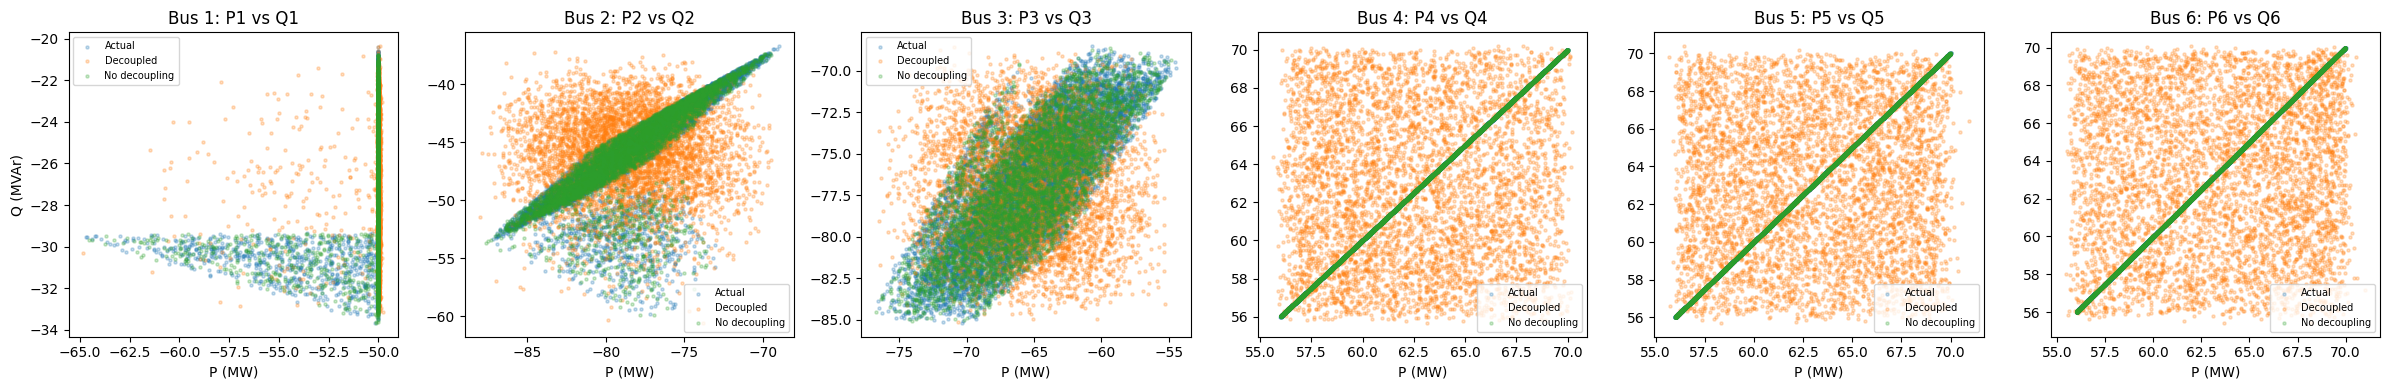

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
# FILE NAMES – change these if your names are different
# -------------------------------------------------------
ACTUAL_CSV      = "/kaggle/input/case-6-actual-data/actual_data_6.csv"
DECOUPLED_CSV   = "ddim_generated_decoupled.csv"
NODECOUPLED_CSV = "/kaggle/input/case6-test-data/test_data_6_5000.csv"

# -------------------------------------------------------
# Load data
# -------------------------------------------------------
actual = pd.read_csv(ACTUAL_CSV)
gen_dec = pd.read_csv(DECOUPLED_CSV)
gen_full = pd.read_csv(NODECOUPLED_CSV)

# Column groups (same logic as before)
p_cols     = [c for c in actual.columns if c.startswith("P")]
q_cols     = [c for c in actual.columns if c.startswith("Q")]
v_cols     = [c for c in actual.columns if c.startswith("V")]
theta_cols = [c for c in actual.columns if c.startswith("Th") or c.startswith("Theta")]

NUM_BUS = len(p_cols)

# -------------------------------------------------------
# Convert from p.u. → MW / MVAr / kV
# (reuses BASE_MVA and net from your PF / OPF code)
# -------------------------------------------------------
actual_nonpu   = actual.copy()
gen_dec_nonpu  = gen_dec.copy()
gen_full_nonpu = gen_full.copy()

# P, Q: per-unit → MW / MVAr
for col in p_cols:
    actual_nonpu[col]   = actual[col]   * BASE_MVA
    gen_dec_nonpu[col]  = gen_dec[col]  * BASE_MVA
    gen_full_nonpu[col] = gen_full[col] * BASE_MVA

for col in q_cols:
    actual_nonpu[col]   = actual[col]   * BASE_MVA
    gen_dec_nonpu[col]  = gen_dec[col]  * BASE_MVA
    gen_full_nonpu[col] = gen_full[col] * BASE_MVA

# V: per-unit → kV using bus nominal voltage
vn_kv = net.bus.vn_kv.values
for i, col in enumerate(v_cols):
    actual_nonpu[col]   = actual[col]   * vn_kv[i]
    gen_dec_nonpu[col]  = gen_dec[col]  * vn_kv[i]
    gen_full_nonpu[col] = gen_full[col] * vn_kv[i]

# -------------------------------------------------------
# Scatter P–Q per bus:
# Actual vs Decoupled vs No-Decoupling
# -------------------------------------------------------
fig, axes = plt.subplots(1, NUM_BUS, figsize=(4*NUM_BUS, 4))

if NUM_BUS == 1:
    axes = [axes]   # handle single-bus case

for i in range(NUM_BUS):
    bus_id = i + 1

    p_col = p_cols[i]
    q_col = q_cols[i]

    ax = axes[i]
    ax.scatter(
        actual_nonpu[p_col], actual_nonpu[q_col],
        alpha=0.25, s=5, label="Actual"
    )
    ax.scatter(
        gen_dec_nonpu[p_col], gen_dec_nonpu[q_col],
        alpha=0.25, s=5, label="Decoupled"
    )
    ax.scatter(
        gen_full_nonpu[p_col], gen_full_nonpu[q_col],
        alpha=0.25, s=5, label="No decoupling"
    )

    ax.set_title(f"Bus {bus_id}: P{bus_id} vs Q{bus_id}")
    ax.set_xlabel("P (MW)")
    if i == 0:
        ax.set_ylabel("Q (MVAr)")
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

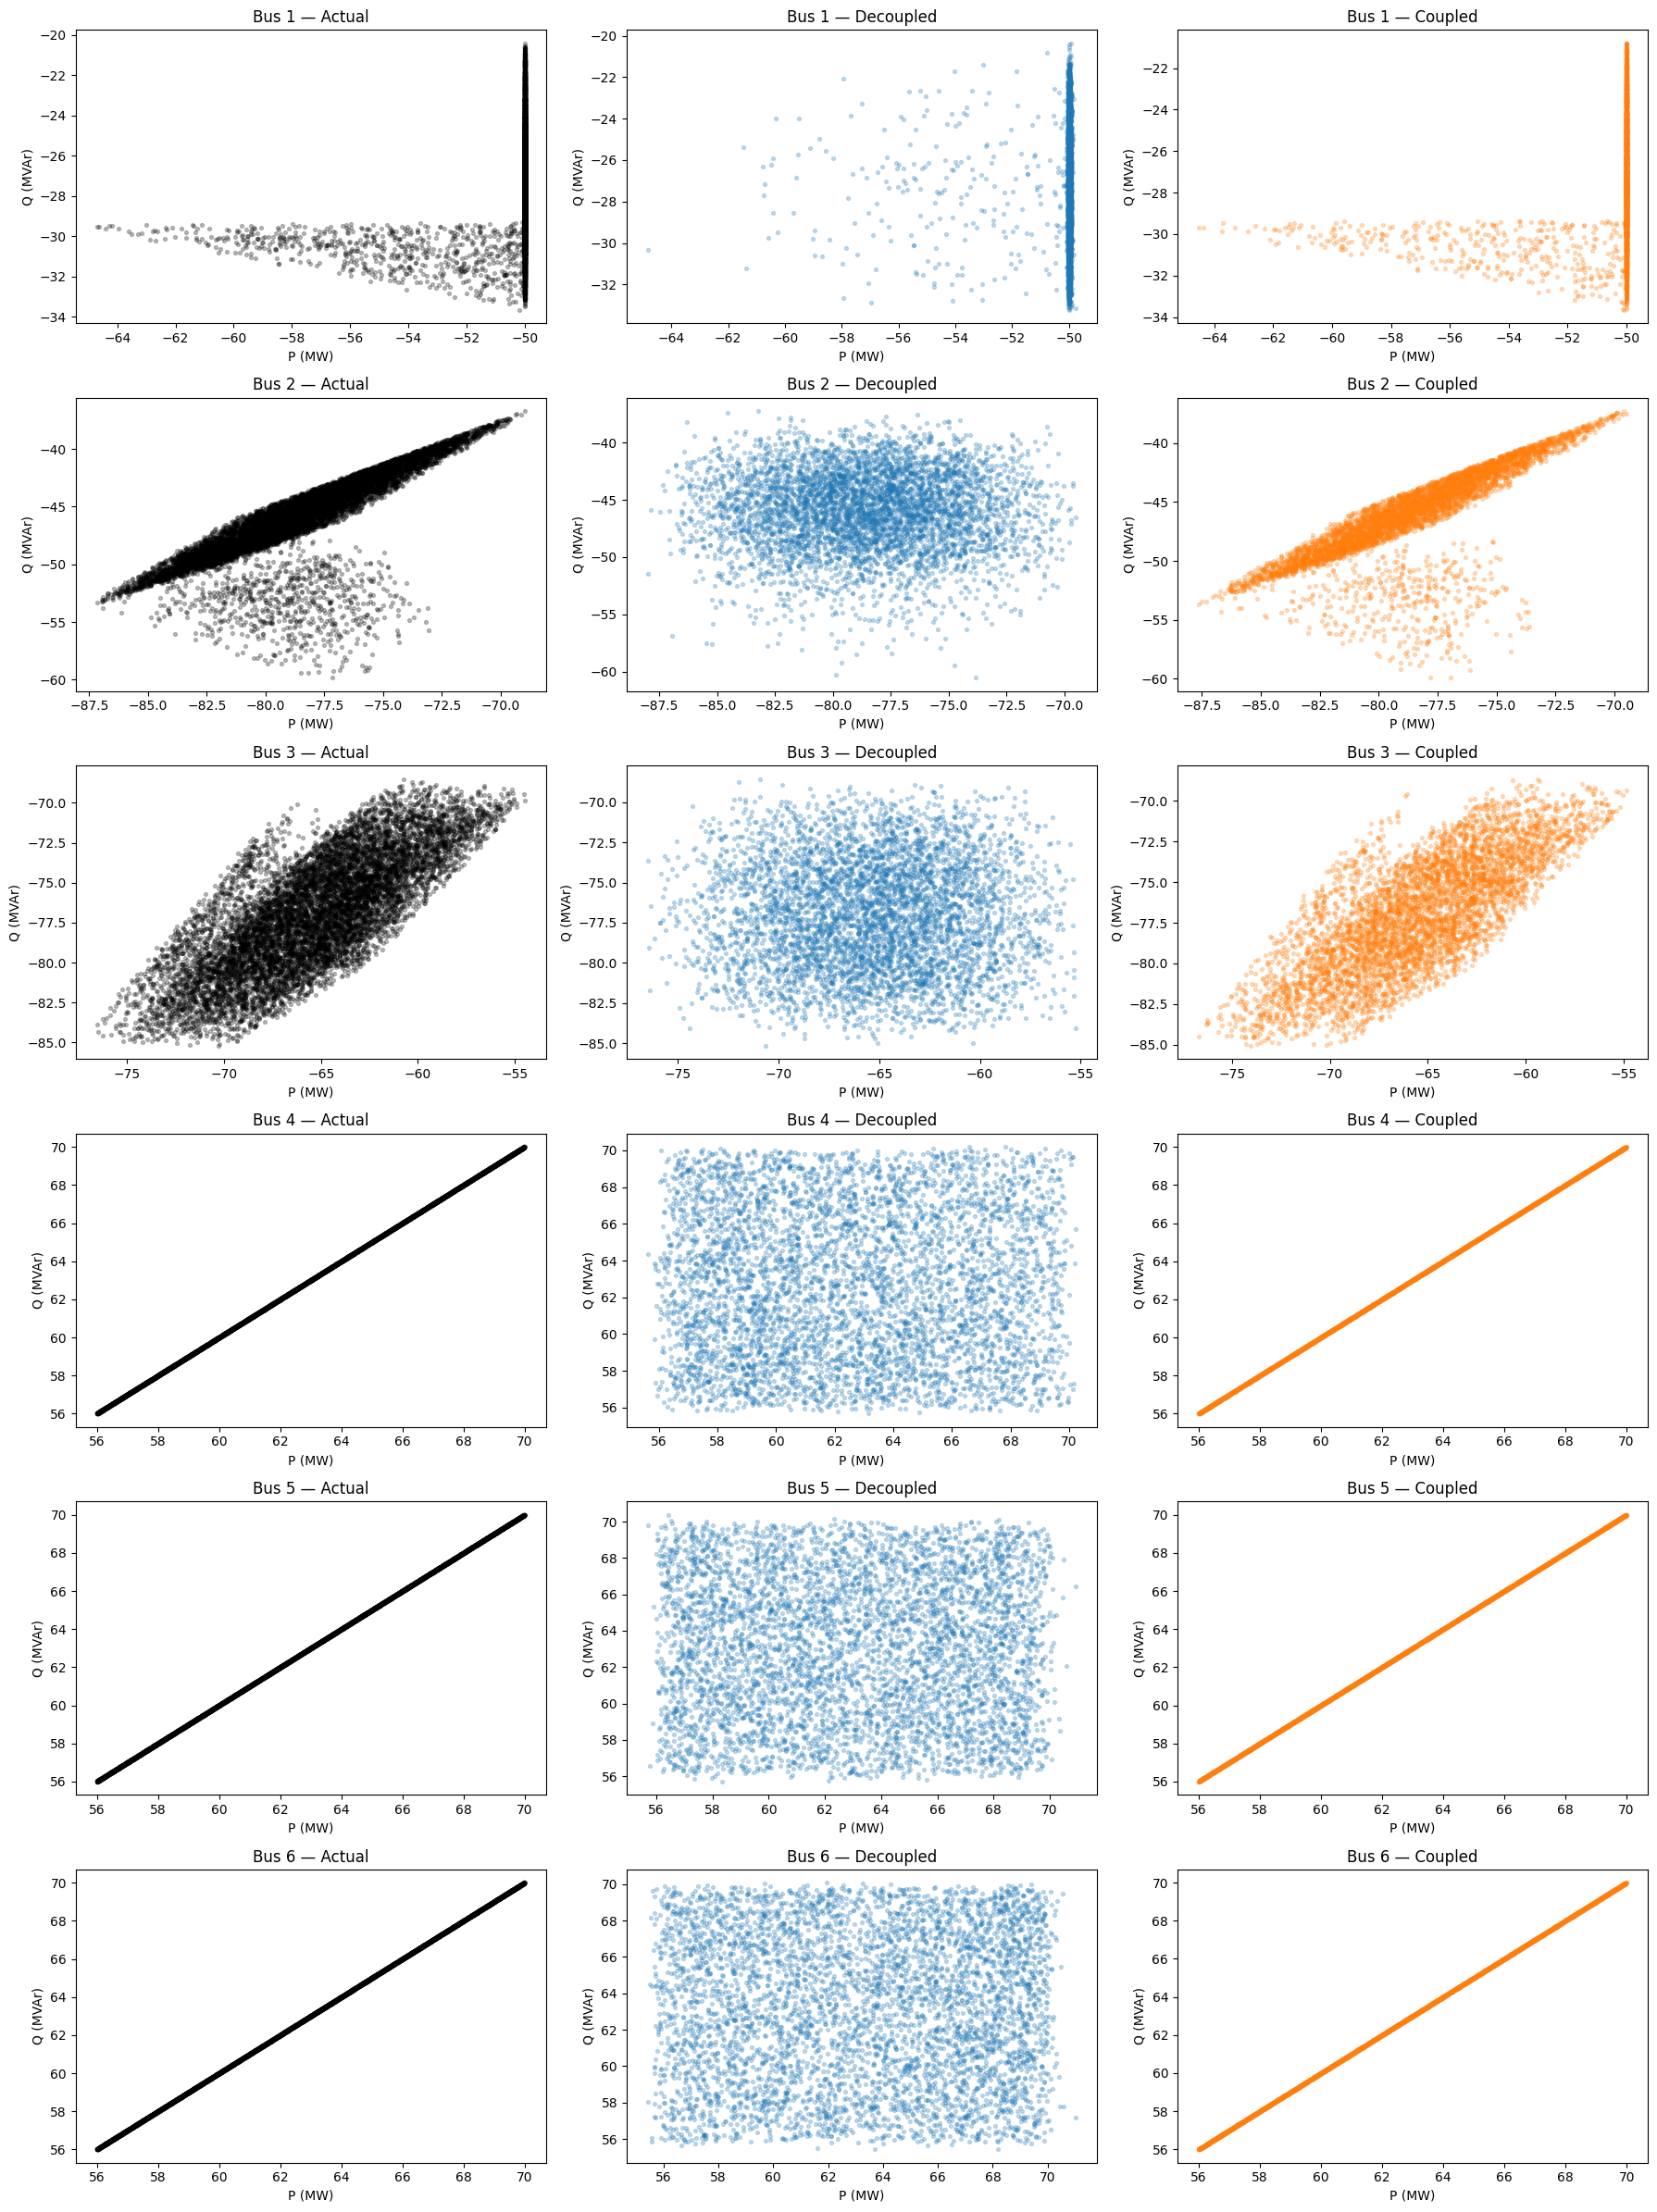

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------------------------------
# P–Q comparison grid:
# Each row = one bus
# Columns = Actual | Decoupled | Coupled
# -------------------------------------------------------

fig, axes = plt.subplots(NUM_BUS, 3, figsize=(18, 4*NUM_BUS))  
# Width = 18 inches (3 plots), Height scales with buses

for i in range(NUM_BUS):
    bus_id = i + 1
    p_col = p_cols[i]
    q_col = q_cols[i]

    # ---------- Col 1: Actual ----------
    axA = axes[i, 0]
    axA.scatter(
        actual_nonpu[p_col], actual_nonpu[q_col],
        alpha=0.25, s=8, color="black"
    )
    axA.set_title(f"Bus {bus_id} — Actual", fontsize=12)
    axA.set_xlabel("P (MW)")
    axA.set_ylabel("Q (MVAr)")

    # ---------- Col 2: Decoupled ----------
    axD = axes[i, 1]
    axD.scatter(
        gen_dec_nonpu[p_col], gen_dec_nonpu[q_col],
        alpha=0.25, s=8, color="tab:blue"
    )
    axD.set_title(f"Bus {bus_id} — Decoupled", fontsize=12)
    axD.set_xlabel("P (MW)")
    axD.set_ylabel("Q (MVAr)")

    # ---------- Col 3: Coupled (Non-decoupled) ----------
    axC = axes[i, 2]
    axC.scatter(
        gen_full_nonpu[p_col], gen_full_nonpu[q_col],
        alpha=0.25, s=8, color="tab:orange"
    )
    axC.set_title(f"Bus {bus_id} — Coupled", fontsize=12)
    axC.set_xlabel("P (MW)")
    axC.set_ylabel("Q (MVAr)")

plt.tight_layout()
plt.show()